# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 


## PROJECT: MIDTERM ELECTIONS


**Harvard University**<br/>
**Fall 2019**<br/><br/>
**Group 74**<br/>
**Students**: Matty Cheng, Tate Huffman, Chris Skokowski<br/>


<hr style="height:2pt">



In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 

from sklearn import tree
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle

import requests, json
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data Collection

In [3]:
# Load election result data already downloaded 
df_results = pd.read_csv("data/1976-2018-house.csv", encoding = 'unicode_escape')

In [4]:
# Create variable for state district combination
df_results["state_district"] = df_results["state"] + df_results["district"].astype(str)
df_results_cut = df_results[(df_results["year"] > 2007) & (df_results["year"] < 2019)]

# Adjust for error in dataset
florida24_idx = df_results_cut.index[(df_results_cut["state_district"] == "Florida24") & (df_results_cut["year"] == 2016)].tolist()[0]
df_results_cut.at[florida24_idx, "candidatevotes"] = 1
df_results_cut.at[florida24_idx, "totalvotes"] = 1

# df_results_2010 = df_results[df_results["year"] == 2010]

display(df_results_cut.head())
# display(df_results_2010.head())

year    state state_po  state_fips  state_cen  state_ic    office  district stage runoff  special     candidate       party  writein   mode candidatevotes  totalvotes  unofficial   version state_district
21172  2008  Alabama       AL           1         63        41  US House         1   gen    NaN    False     Jo Bonner  republican    False  total         210660    214367.0       False  20171005       Alabama1
21173  2008  Alabama       AL           1         63        41  US House         1   gen    NaN    False           NaN         NaN     True  total           3707    214367.0       False  20171005       Alabama1
21174  2008  Alabama       AL           1         63        41  US House         2   gen    NaN    False      Jay Love  republican    False  total         142578    287394.0       False  20171005       Alabama2
21175  2008  Alabama       AL           1         63        41  US House         2   gen    NaN    False           NaN         NaN     True  total            448    287394.0       False  20171005       Alabama2
21176  2008  Alabama       AL           1         63        41  US House         2   gen    NaN    False  Bobby Bright    democrat    False  total         144368    287394.0       False  20171005       Alabama2

In [5]:
def clean_results_data(df, out_name):
    """
        Creates new dataset that shows party winners of each state
    """
    for index, row in df.iterrows():
        df.at[index, "candidatevotes"] = float(str(row["candidatevotes"]).replace(',',''))
        df.at[index, "totalvotes"] = float(str(row["totalvotes"]).replace(',',''))

    df["vote_pct"] = df["candidatevotes"].astype(float)/df["totalvotes"].astype(float)
    df["win"] = 0

    # Get winner for each year
    for year, df_year in df.groupby(["year"]):
        for name, group in df_year.groupby(["state_district"]):
            idxmax = group["vote_pct"].idxmax()
            df.at[idxmax, "win"] = 1


    df_out = df[df["win"] == 1]
    df_out = df_out[["year", "state_district", "party", "candidate", "vote_pct"]]

    new_data = []
    # Get previous winner
    for name, df_group in df_out.groupby(["state_district"]):
        # print(df_group)
        party_history = [""] + df_group["party"].tolist()[:-1]
        candidate_history = [""] + df_group["candidate"].tolist()[:-1]
        candidate_vote_history = [""] + df_group["vote_pct"].tolist()[:-1]

        # print(party_history)
        df_group["party_incumbent"] = party_history
        df_group["candidate_incumbent_name"] = candidate_history
        df_group["candidate_incumbent_vote_pct"] = candidate_vote_history
        # print(df_out)
        new_data.append(df_group)
        # print(new_data)
        # return

    df_final = pd.concat(new_data)

    df_final["candidate_incumbent"] = np.where(df_final["candidate"] == df_final["candidate_incumbent_name"], 1, 0)
    df_final["candidate_incumbent_vote"] = np.where(df_final["candidate_incumbent"] == 1, df_final["candidate_incumbent_vote_pct"], 0)

    df_final.drop(columns=["candidate", "vote_pct", "candidate_incumbent_name", "candidate_incumbent_vote_pct"], inplace=True)
    df_final.sort_values(by=["year", "state_district"], inplace=True)
    df_final = df_final[df_final["year"] > 2009]
    # print(df_final)
    
    df_final.to_csv(f"data_clean/{out_name}.csv", encoding='utf-8', index=False)
    return df_final

In [6]:
df_results_cut_clean = clean_results_data(df_results_cut, "all_winners")
# df_results_2018_clean = clean_results_data(df_results_2018, "2018_winners")

# display(df_results_cut_clean.head())
# display(df_results_2018_clean.head())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [7]:
def clean_pre_results_data(df, out_name):
    """
        Creates new dataset that shows party winners of each state before the training dataset (used for historical party win percentage)
    """
    for index, row in df.iterrows():
        df.at[index, "candidatevotes"] = float(str(row["candidatevotes"]).replace(',',''))
        df.at[index, "totalvotes"] = float(str(row["totalvotes"]).replace(',',''))

    df["vote_pct"] = df["candidatevotes"].astype(float)/df["totalvotes"].astype(float)
    df["win"] = 0

    # Get winner for each year
    for year, df_year in df.groupby(["year"]):
        for name, group in df_year.groupby(["state_district"]):
            idxmax = group["vote_pct"].idxmax()
            df.at[idxmax, "win"] = 1


    df_out = df[df["win"] == 1]
    df_out = df_out[["year", "state_district", "party", "candidate", "vote_pct"]]


    df_out.to_csv(f"data_clean/{out_name}.csv", encoding='utf-8', index=False)
    return df_out


df_pre_results = df_results[(df_results["year"] < 2007)]

df_pre_results_clean = clean_pre_results_data(df_pre_results, "pre_winners")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
# Create dataset with historical Republican win percentage
df_pre_results_final = pd.read_csv("data_clean/pre_winners.csv")

output = []

df_pre_results_final["party_result"] = np.where(df_pre_results_final["party"] == "republican", 1, 0)

for state_district, df_group in df_pre_results_final.groupby(["state_district"]):
    output.append({"state_district": state_district, "R_win_pct": df_group["party_result"].mean()})

df_state_district_history = pd.DataFrame(output, columns=["state_district", "R_win_pct"])
df_state_district_history.to_csv(f"data_clean/state_district_history.csv", encoding='utf-8', index=False)
display(df_state_district_history.head())

state_district  R_win_pct
0       Alabama1      1.000
1       Alabama2      1.000
2       Alabama3      0.375
3       Alabama4      0.375
4       Alabama5      0.000

In [9]:
# Combine winner dataset for 2010-2018 with the historical party win percentage
df_state_district_history = pd.read_csv("data_clean/state_district_history.csv")
df_all_winners = pd.read_csv("data_clean/all_winners.csv")
his_dict = {list(df_state_district_history["state_district"].values)[i]: list(df_state_district_history["R_win_pct"].values)[i] for i in range(len(df_state_district_history.index))} 
print("All winners Before shape: ", df_all_winners.shape)

df_all_winners["R_win_pct"] = 0.5
state_dis = list(set(list(df_all_winners["state_district"].values)))

for index, row in df_all_winners.iterrows():
    try: r_win_pct = his_dict[row["state_district"]]
    except: r_win_pct = 0.5
    df_all_winners.at[index, "R_win_pct"] = r_win_pct

df_all_winners.to_csv(f"data_clean/all_winners_final.csv", encoding='utf-8', index=False)
print("After shape: ", df_all_winners.shape)

display(df_all_winners.head())

All winners Before shape:  (2175, 6)
After shape:  (2175, 7)


year state_district       party party_incumbent  candidate_incumbent  candidate_incumbent_vote  R_win_pct
0  2010       Alabama1  republican      republican                    1                  0.982707      1.000
1  2010       Alabama2  republican        democrat                    0                  0.000000      1.000
2  2010       Alabama3  republican      republican                    1                  0.540315      0.375
3  2010       Alabama4  republican      republican                    1                  0.747590      0.375
4  2010       Alabama5  republican        democrat                    0                  0.000000      0.000

In [10]:
# Dictionary of data fields
fields_dict = {
    "B01001_001E": "Total population",

    "B01001_002E": "Male",
    "B01001_026E": "Female",

    "B02001_002E": "White alone",
    "B02001_003E": "Black or African American alone",
    "B02001_004E": "American Indian & Alaska Native alone",
    "B02001_005E": "Asian alone",
    "B02001_006E": "Native Hawaiian & Other Pacific Islander alone",
    "B02001_007E": "Some other race alone",
    "B02001_008E":" Two or more races",
    "B03003_003E": "Hispanic or Latino (any race)",


    "B19013_001E": "Median household income",
    "B19301_001E": "Per capita income",
    "B25077_001E": "Median housing value",
    "B19083_001E": "Gini index of income inequality",

    "B25064_001E": "Median gross rent",

     # Demographics
    "B01002_001E": "Median age",

    # Finances
    "B07011_001E": "Median income",
    "B17001A_002E": "Income in the past 12 months below poverty level",
    "B17001A_031E": "Income in the past 12 months at or above poverty level:",
    "C05010_001E": "RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS",

    # Education
    "C14002_002E": "Total enrolled in school",
    "C14002_024E": "Total not enrolled in school", # CREATE RATIO
    "C14003_002E": "Total enrolled in public school",
    "C14003_011E": "Total enrolled in private school",

    "B15002_002E": "Males for population", # USE FOR PCT
    "B15002_010E": "Males 12th grade, no diploma",
    "B15002_011E": "Males Highschool diploma",
    "B15002_015E": "Males Bachelor's degree",

    "B15002_019E": "Females for population", # USE FOR PCT
    "B15002_027E": "Females 12th grade, no diploma",
    "B15002_028E": "Females Highschool diploma",
    "B15002_032E": "Females Bachelor's degree",

    # Language
    "B16001_001E": "Total pop over 5", # Use for PCT
    "B16001_002E": "Speak only English",

    # Employment
    "B17005_001E": "Males for population poverty", # Use for PCT
    "B17005_006E": "Males unemployed",
    
    # Income
    "B17011_001E": "Aggregate income deficit in the past 12 months",
    "B19025_001E": "Aggregate household income in the past 12 months (in 2016 inflation-adjusted dollars)",

    "B19001A_001E": "Household population", # Use for PCT
    "B19001A_017E": "$200,000 or more",
    "B19001A_002E": "Less than $10,000",

    # Veteran
    "B21001_001E": "Population for veterans", # Use for PCT
    "B21001_002E": "Veteran",

    "C24070_001E": "Population for employment",
    "C24070_002E": "Agriculture, forestry, fishing and hunting, and mining",
    "C24070_009E": "Finance and insurance, and real estate and rental and leasing",
    "C24070_010E": "Professional, scientific, and management, and administrative and waste management services",

    "NAME": "NAME",
}

# Fields to convert to percentages relative to total population
pct_fields = ['Male', 'Female', 'White alone', 'Black or African American alone', 'American Indian & Alaska Native alone', 'Asian alone', 'Native Hawaiian & Other Pacific Islander alone', 'Some other race alone', ' Two or more races', 'Hispanic or Latino (any race)']

# Fields to convert to percentages relative to various populations
ratio_fields_dict = {
    "Speak only English": "Total pop over 5",

    "Total not enrolled in school": "Total enrolled in school",
    "Total enrolled in public school": "Total enrolled in school",
    "Total enrolled in private school": "Total enrolled in school",

    "Males 12th grade, no diploma": "Males for population",
    "Males Highschool diploma": "Males for population",
    "Males Bachelor's degree": "Males for population",

    "Females 12th grade, no diploma": "Females for population",
    "Females Highschool diploma": "Females for population",
    "Females Bachelor's degree": "Females for population",

    "Males unemployed": "Males for population poverty",
    "$200,000 or more": "Household population",
    "Less than $10,000": "Household population",

    "Veteran": "Population for veterans",

    "Agriculture, forestry, fishing and hunting, and mining": "Population for employment",
    "Finance and insurance, and real estate and rental and leasing": "Population for employment",
    "Professional, scientific, and management, and administrative and waste management services": "Population for employment",
}


def get_census_data(year, fields):
    """
        Scrapes Census Data From US Goverment API
    """
    link = "https://api.census.gov/data/" + str(year) + "/acs/acs1?get=" + fields + "&for=congressional%20district:*"
    print(link)
    response = requests.get(link)
    
    return json.loads(response.content.decode('utf-8'))

def write_json(filename, data):
    """
        Write json file
    """
    if data is not None:
        with open(filename+'.json', 'w') as outfile:  
            json.dump(data, outfile)
    else: print("No data to write")

In [11]:
# Scrape census data
output_dfs = []
for year in [2010, 2012, 2014, 2016, 2018]:
    census_data = get_census_data(year, ",".join(list(fields_dict.keys())))
    census_data[0] = list(fields_dict.values()) + ['state', 'congressional district']

    df_census = pd.DataFrame(census_data[1:], columns=census_data[0])
    df_census["year"] = year
    output_dfs.append(df_census)
    # write_json(f"data/census_{year}", census_data)

df_census_raw_out = pd.concat(output_dfs)
df_census_raw_out.to_csv(f"data/census_all.csv", encoding='utf-8', index=False)

https://api.census.gov/data/2010/acs/acs1?get=B01001_001E,B01001_002E,B01001_026E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B03003_003E,B19013_001E,B19301_001E,B25077_001E,B19083_001E,B25064_001E,B01002_001E,B07011_001E,B17001A_002E,B17001A_031E,C05010_001E,C14002_002E,C14002_024E,C14003_002E,C14003_011E,B15002_002E,B15002_010E,B15002_011E,B15002_015E,B15002_019E,B15002_027E,B15002_028E,B15002_032E,B16001_001E,B16001_002E,B17005_001E,B17005_006E,B17011_001E,B19025_001E,B19001A_001E,B19001A_017E,B19001A_002E,B21001_001E,B21001_002E,C24070_001E,C24070_002E,C24070_009E,C24070_010E,NAME&for=congressional%20district:*
https://api.census.gov/data/2012/acs/acs1?get=B01001_001E,B01001_002E,B01001_026E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B03003_003E,B19013_001E,B19301_001E,B25077_001E,B19083_001E,B25064_001E,B01002_001E,B07011_001E,B17001A_002E,B17001A_031E,C05010_001E,C14002_002E,C14002_024E,C14003_002E,C

In [12]:
def clean_census_data():
    """
        Takes the downloaded census data and adds new column for state district name, converts some columns to percentages
    """
  
    df_census = pd.read_csv("data/census_all.csv")

    df_census["state_name"] = ""
    df_census["state_district"] = ""

    for index, row in df_census.iterrows():
        # print(int(row["state"]))
        state_name = row["NAME"].split(", ")[-1]
        df_census.at[index, "state_name"] = state_name
        df_census.at[index, "state_district"] = state_name + str(int(row["congressional district"]))

    # Adjust columns and sorting
    cols_first = ["year", "NAME", "state", "congressional district", "state_name", "state_district"]
    cols_last = [x for x in list(df_census) if x not in set(cols_first)]

    cols_formatted = cols_first + cols_last
    df_census = df_census[cols_formatted]
    df_census = df_census.sort_values(by=["year", "state", "congressional district"])


    output = []
    
    for key in pct_fields: df_census[key + " PCT"] = df_census[key]/df_census["Total population"]
    df_census.drop(columns=pct_fields, inplace=True)

    for key in ratio_fields_dict: df_census[key + " PCT"] =df_census[key]/df_census[ratio_fields_dict[key]]
    df_census.drop(columns=[*list(ratio_fields_dict.keys()), *list(set(ratio_fields_dict.values()))], inplace=True)
    
    exclude_names = ["Resident Commissioner District (at Large) (115th Congress), Puerto Rico", "Delegate District (at Large) (115th Congress), District of Columbia"]
    df_census_out = df_census[~df_census["NAME"].isin(exclude_names)]

    # df_census_out = pd.DataFrame(output)
    df_census_out.to_csv(f"data_clean/census_all.csv", encoding='utf-8', index=False)

In [13]:
clean_census_data()

In [14]:
df_census_raw = pd.read_csv("data/census_all.csv")
display(df_census_raw.head())

Total population    Male  Female  White alone  Black or African American alone  American Indian & Alaska Native alone  Asian alone  Native Hawaiian & Other Pacific Islander alone  Some other race alone   Two or more races  Hispanic or Latino (any race)  Median household income  Per capita income  Median housing value  Gini index of income inequality  Median gross rent  Median age  Median income  Income in the past 12 months below poverty level  Income in the past 12 months at or above poverty level:  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS  Total enrolled in school  Total not enrolled in school  Total enrolled in public school  Total enrolled in private school  Males for population  Males 12th grade, no diploma  Males Highschool diploma  Males Bachelor's degree  Females for population  Females 12th grade, no diploma  Females Highschool diploma  Females Bachelor's degree  Total pop over 5  Speak only English  Males for population poverty  Males unemployed  Aggregate income deficit in the past 12 months  Aggregate household income in the past 12 months (in 2016 inflation-adjusted dollars)  Household population  $200,000 or more  Less than $10,000  Population for veterans  Veteran  Population for employment  Agriculture, forestry, fishing and hunting, and mining  Finance and insurance, and real estate and rental and leasing  \
0            689835  338130  351705       464769                           194656                                   8000         9816                                              53                   4551                7990                          19394                    41172              21773                136000                            0.478                709        38.4        21250.0                                             62151                                             393944                                                   156796                                                                                                                   175653                        485887                           147575                             28078                217806                          4983                     75436                    31840                  240994                            4410                       75223                      36101               NaN                 NaN                        529469              7088                                     252961400.0                                        14275574200                                                    179412              6308              14146                   519263    62812                     277703                                               4264                                                   15918               
1            666779  319635  347144       431666                           206236                                   2713         5874                                             179                   5838               14273                          18587                    40567              21076                111200                            0.449                659        37.7        21548.0                                             50371                                             371220                                                   150164                                                                                                                   170261                        470838                           142916                             27345                207723                          3574                     69565                    26718                  232795                            3997                       75307                      26885               NaN                 NaN                        499309              4937                   

## EDA

In [15]:
# Load datasets
df_census_all_clean = pd.read_csv("data_clean/census_all.csv")
df_winners_all_clean = pd.read_csv("data_clean/all_winners_final.csv")

display(df_census_all_clean.head())
display(df_winners_all_clean.head())
# display(df_winners_2018_clean.head())

year                                               NAME  state  congressional district state_name state_district  Total population  Median household income  Per capita income  Median housing value  Gini index of income inequality  Median gross rent  Median age  Median income  Income in the past 12 months below poverty level  Income in the past 12 months at or above poverty level:  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS  Aggregate income deficit in the past 12 months  Aggregate household income in the past 12 months (in 2016 inflation-adjusted dollars)  Male PCT  Female PCT  White alone PCT  Black or African American alone PCT  American Indian & Alaska Native alone PCT  Asian alone PCT  Native Hawaiian & Other Pacific Islander alone PCT  Some other race alone PCT   Two or more races PCT  Hispanic or Latino (any race) PCT  Speak only English PCT  Total not enrolled in school PCT  Total enrolled in public school PCT  Total enrolled in private school PCT  Males 12th grade, no diploma PCT  Males Highschool diploma PCT  Males Bachelor's degree PCT  Females 12th grade, no diploma PCT  Females Highschool diploma PCT  Females Bachelor's degree PCT  Males unemployed PCT  $200,000 or more PCT  Less than $10,000 PCT  Veteran PCT  Agriculture, forestry, fishing and hunting, and mining PCT  Finance and insurance, and real estate and rental and leasing PCT  \
0  2010  Congressional District 1 (111th Congress), Ala...      1                       1    Alabama       Alabama1            689835                    41172              21773                136000                            0.478                709        38.4        21250.0                                             62151                                             393944                                                   156796                                                                                                                                    252961400.0                                        14275574200                                      0.490161    0.509839         0.673739                             0.282178                                   0.011597         0.014229                                           0.000077                    0.006597                0.011582                           0.028114                     NaN                          2.766175                             0.840151                              0.159849                          0.022878                      0.346345                     0.146185                            0.018299                        0.312136                       0.149800              0.013387              0.035159               0.078846     0.120964                                           0.015355                                                    0.057320                   
1  2010  Congressional District 2 (111th Congress), Ala...      1                       2    Alabama       Alabama2            666779                    40567              21076                111200                            0.449                659        37.7        21548.0                                             50371                                             371220                                                   150164                                                                                                                                    225112400.0                                        13534983400                                      0.479372    0.520628         0.647390                             0.309302                                   0.004069         0.008810                                           0.000268                    0.008756                0.021406                           0.027876                     NaN                          2.765390                             0.839394                

year state_district       party party_incumbent  candidate_incumbent  candidate_incumbent_vote  R_win_pct
0  2010       Alabama1  republican      republican                    1                  0.982707      1.000
1  2010       Alabama2  republican        democrat                    0                  0.000000      1.000
2  2010       Alabama3  republican      republican                    1                  0.540315      0.375
3  2010       Alabama4  republican      republican                    1                  0.747590      0.375
4  2010       Alabama5  republican        democrat                    0                  0.000000      0.000

In [16]:
# Merge election results and census data
df_all = pd.merge(df_winners_all_clean, df_census_all_clean, on=['year', 'state_district'], how='inner')
df_all.drop(columns=["NAME", "state", "congressional district", "state_name", "Total population"], inplace=True)
df_all["party_result"] = df_all["party"].apply(lambda k: 1 if k == "republican" else 0)
df_all["party_incumbent"] = df_all["party_incumbent"].apply(lambda k: 1 if k == "republican" else 0)

# Fill median value for blanks
df_all["Speak only English PCT"] = df_all["Speak only English PCT"].fillna(df_all["Speak only English PCT"].median())
df_all["Aggregate income deficit in the past 12 months"] = df_all["Aggregate income deficit in the past 12 months"].fillna(df_all["Aggregate income deficit in the past 12 months"].median())

df_2018 = df_all[df_all["year"] == 2018]
df_train = df_all[df_all["year"] < 2018]

display(df_train.head())
display(df_2018.head())

year state_district       party  party_incumbent  candidate_incumbent  candidate_incumbent_vote  R_win_pct  Median household income  Per capita income  Median housing value  Gini index of income inequality  Median gross rent  Median age  Median income  Income in the past 12 months below poverty level  Income in the past 12 months at or above poverty level:  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS  Aggregate income deficit in the past 12 months  Aggregate household income in the past 12 months (in 2016 inflation-adjusted dollars)  Male PCT  Female PCT  White alone PCT  Black or African American alone PCT  American Indian & Alaska Native alone PCT  Asian alone PCT  Native Hawaiian & Other Pacific Islander alone PCT  Some other race alone PCT   Two or more races PCT  Hispanic or Latino (any race) PCT  Speak only English PCT  Total not enrolled in school PCT  Total enrolled in public school PCT  Total enrolled in private school PCT  Males 12th grade, no diploma PCT  Males Highschool diploma PCT  Males Bachelor's degree PCT  Females 12th grade, no diploma PCT  Females Highschool diploma PCT  Females Bachelor's degree PCT  Males unemployed PCT  $200,000 or more PCT  Less than $10,000 PCT  Veteran PCT  Agriculture, forestry, fishing and hunting, and mining PCT  Finance and insurance, and real estate and rental and leasing PCT  \
0  2010       Alabama1  republican                1                    1                  0.982707      1.000                    41172              21773                136000                            0.478                709        38.4        21250.0                                             62151                                             393944                                                   156796                                                                                                                                    252961400.0                                        14275574200                                      0.490161    0.509839         0.673739                             0.282178                                   0.011597         0.014229                                           0.000077                    0.006597                0.011582                           0.028114                0.703508                          2.766175                             0.840151                              0.159849                          0.022878                      0.346345                     0.146185                            0.018299                        0.312136                       0.149800              0.013387              0.035159               0.078846     0.120964                                           0.015355                                                    0.057320                   
1  2010       Alabama2  republican                0                    0                  0.000000      1.000                    40567              21076                111200                            0.449                659        37.7        21548.0                                             50371                                             371220                                                   150164                                                                                                                                    225112400.0                                        13534983400                                      0.479372    0.520628         0.647390                             0.309302                                   0.004069         0.008810                                           0.000268                    0.008756                0.021406                           0.027876                0.703508                          2.765390                             0.839394                              0.160606                          0.017206                

year state_district       party  party_incumbent  candidate_incumbent  candidate_incumbent_vote  R_win_pct  Median household income  Per capita income  Median housing value  Gini index of income inequality  Median gross rent  Median age  Median income  Income in the past 12 months below poverty level  Income in the past 12 months at or above poverty level:  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS  Aggregate income deficit in the past 12 months  Aggregate household income in the past 12 months (in 2016 inflation-adjusted dollars)  Male PCT  Female PCT  White alone PCT  Black or African American alone PCT  American Indian & Alaska Native alone PCT  Asian alone PCT  Native Hawaiian & Other Pacific Islander alone PCT  Some other race alone PCT   Two or more races PCT  Hispanic or Latino (any race) PCT  Speak only English PCT  Total not enrolled in school PCT  Total enrolled in public school PCT  Total enrolled in private school PCT  Males 12th grade, no diploma PCT  Males Highschool diploma PCT  Males Bachelor's degree PCT  Females 12th grade, no diploma PCT  Females Highschool diploma PCT  Females Bachelor's degree PCT  Males unemployed PCT  $200,000 or more PCT  Less than $10,000 PCT  Veteran PCT  Agriculture, forestry, fishing and hunting, and mining PCT  Finance and insurance, and real estate and rental and leasing PCT  \
1740  2018       Alabama1  republican                1                    1                  0.963825      1.000                    46445              26561                152100                           0.4824                844        40.3        25963.0                                             51049                                             420206                                                   149607                                                                                                                                    226883800.0                                        17907552200                                      0.481645    0.518355         0.670933                             0.275239                                   0.009774         0.014856                                           0.000256                    0.010751                0.018191                           0.033747                0.703508                          3.243251                             0.839626                              0.160374                          0.024710                      0.362440                     0.159038                            0.016104                        0.306495                       0.163089              0.005585              0.047949               0.060267     0.093795                                           0.013738                                                    0.055777                   
1741  2018       Alabama2  republican                1                    1                  0.487685      1.000                    48290              25917                129700                           0.4763                778        38.8        24810.0                                             48607                                             365687                                                   143615                                                                                                                                    236334900.0                                        16457270400                                      0.481250    0.518750         0.629199                             0.321442                                   0.004185         0.010974                                           0.000038                    0.012030                0.022130                           0.036797                0.703508                          3.121328                             0.839067                              0.160933                          0.022508          

In [17]:
def ttest(means: list, stds: list, counts: list) -> float:
    """Calculate t-test value. 
       
       Args:
           means: List of means
           y_actual: List of stds
           y_predict: List of counts
       Returns:
           Float with t-test value    
    """
    t = (means[0]-means[1])/np.sqrt((stds[0]**2)/counts[0] + (stds[1]**2)/counts[1])
    return t

In [18]:
predictors = []
# Calculate t-test value for each variable

df_party0 = df_train[df_train["party_result"] == 0]
df_party1 = df_train[df_train["party_result"] == 1]

for col in df_train.columns:
    if col not in ["year", "state_district", "party", "party_result"]:
        stds = [df_party0[col].std(), df_party1[col].std()]
        means = [df_party0[col].mean(), df_party1[col].mean()]
        counts = [df_party0[col].count(), df_party1[col].count()]
        
        t_value = ttest(means, stds, counts)
        predictors.append({"feature": col, "t_value": t_value, "t_value_abs": np.abs(t_value)})

In [19]:
# Create dataframe of features by t-value
df_features = pd.DataFrame(predictors, columns=["feature", "t_value", "t_value_abs"])
df_features = df_features.sort_values(by=["t_value_abs"], ascending=False)
best_predictor = df_features["feature"].values[0]
df_features.reset_index(inplace=True, drop=True)
display(df_features.head())
display(df_features.shape)
# df_features.to_csv(f"data_out/features.csv", encoding='utf-8', index=False)

feature    t_value  t_value_abs
0                                    party_incumbent -59.700858    59.700858
1  Income in the past 12 months at or above pover... -25.240390    25.240390
2                                    White alone PCT -23.920949    23.920949
3                                          R_win_pct -21.271819    21.271819
4                                        Veteran PCT -19.128197    19.128197

(43, 3)

In [20]:
import seaborn as sns
sns.set()

def plot_feature_histogram(feature, xlabel):
    """
        Plot histogram of values of feature by party_result for training and test set
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 12))

    # Plot histogram of values of feature by party_result for the training dataset
    ax[0].hist(df_train[df_train["party_result"] == 1][feature], alpha=0.4, color="red", label="Republican")
    ax[0].hist(df_train[df_train["party_result"] == 0][feature], alpha=0.5, color="blue",  label="Democrat")
    ax[0].set_title(f"Training Set (2016): Histogram of {feature}")

    # Plot histogram of values of feature by party_result for the test dataset
    ax[1].hist(df_2018[df_2018["party_result"] == 1][feature], alpha=0.4, color="red", label="Republican")
    ax[1].hist(df_2018[df_2018["party_result"] == 0][feature], alpha=0.5, color="blue", label="Democrat")
    ax[1].set_title(f"Test Set (2018): Histogram of {feature}")

    # Set axis labels and legend
    for i in range(2):
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel('Count')
        ax[i].legend()

    plt.savefig(f"img_final/{feature}.png")
    plt.show()


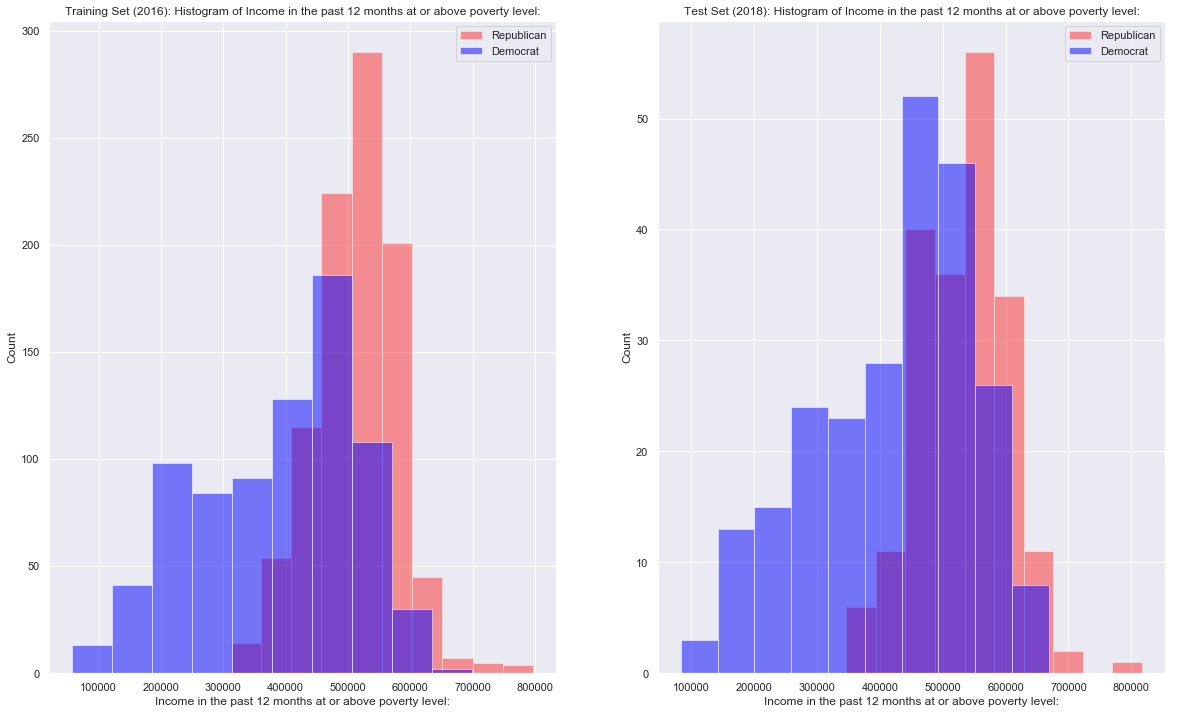

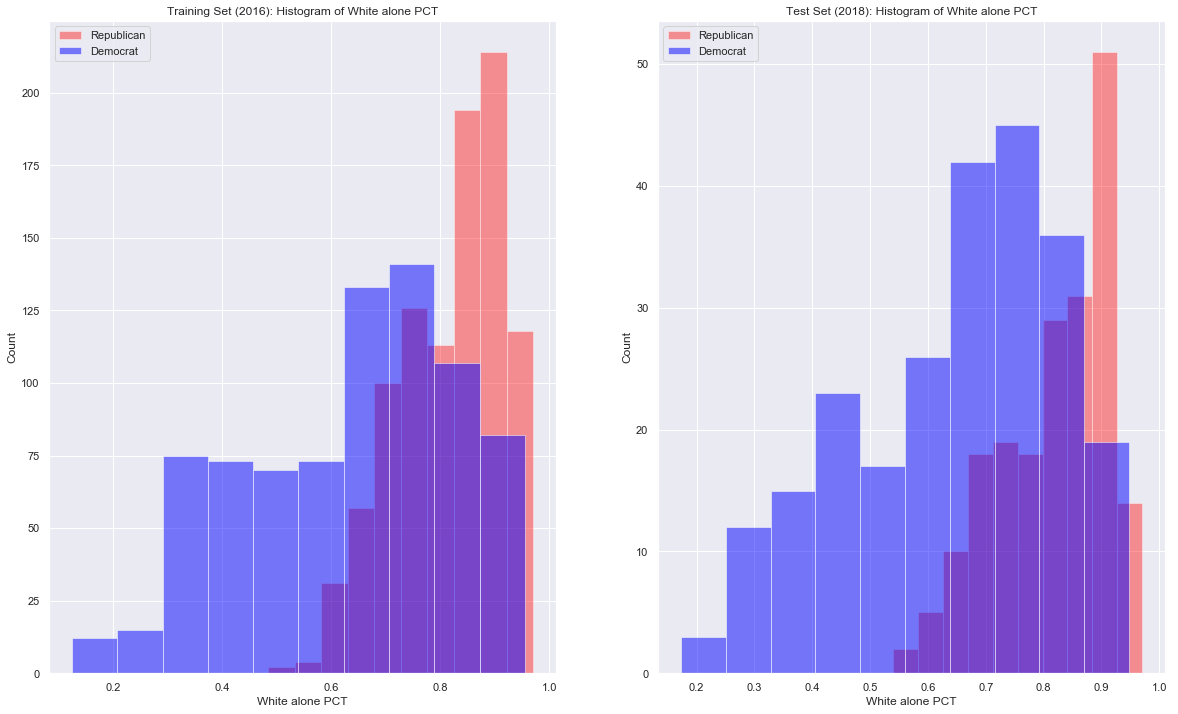

In [21]:
# Select which variables to plot
for i in range(1, 3):
    plot_feature_histogram(df_features["feature"].values[i], df_features["feature"].values[i])

In [22]:
# Split datasets into X, Y and train, test sets
y_train = df_train["party_result"]
y_test = df_2018["party_result"]
X_train = df_train.drop(columns=["year", "state_district", "party", "party_result"])
X_test = df_2018.drop(columns=["year", "state_district", "party", "party_result"])
# len(df_2016.index)
display(X_train.head())
display(X_train.shape)
display(y_train.head())

party_incumbent  candidate_incumbent  candidate_incumbent_vote  R_win_pct  Median household income  Per capita income  Median housing value  Gini index of income inequality  Median gross rent  Median age  Median income  Income in the past 12 months below poverty level  Income in the past 12 months at or above poverty level:  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS  Aggregate income deficit in the past 12 months  Aggregate household income in the past 12 months (in 2016 inflation-adjusted dollars)  Male PCT  Female PCT  White alone PCT  Black or African American alone PCT  American Indian & Alaska Native alone PCT  Asian alone PCT  Native Hawaiian & Other Pacific Islander alone PCT  Some other race alone PCT   Two or more races PCT  Hispanic or Latino (any race) PCT  Speak only English PCT  Total not enrolled in school PCT  Total enrolled in public school PCT  Total enrolled in private school PCT  Males 12th grade, no diploma PCT  Males Highschool diploma PCT  Males Bachelor's degree PCT  Females 12th grade, no diploma PCT  Females Highschool diploma PCT  Females Bachelor's degree PCT  Males unemployed PCT  $200,000 or more PCT  Less than $10,000 PCT  Veteran PCT  Agriculture, forestry, fishing and hunting, and mining PCT  Finance and insurance, and real estate and rental and leasing PCT  \
0                1                    1                  0.982707      1.000                    41172              21773                136000                            0.478                709        38.4        21250.0                                             62151                                             393944                                                   156796                                                                                                                                    252961400.0                                        14275574200                                      0.490161    0.509839         0.673739                             0.282178                                   0.011597         0.014229                                           0.000077                    0.006597                0.011582                           0.028114                0.703508                          2.766175                             0.840151                              0.159849                          0.022878                      0.346345                     0.146185                            0.018299                        0.312136                       0.149800              0.013387              0.035159               0.078846     0.120964                                           0.015355                                                    0.057320                   
1                0                    0                  0.000000      1.000                    40567              21076                111200                            0.449                659        37.7        21548.0                                             50371                                             371220                                                   150164                                                                                                                                    225112400.0                                        13534983400                                      0.479372    0.520628         0.647390                             0.309302                                   0.004069         0.008810                                           0.000268                    0.008756                0.021406                           0.027876                0.703508                          2.765390                             0.839394                              0.160606                          0.017206                      0.334893                     0.128623                            0.017170                    

(1740, 43)

0    1
1    1
2    1
3    1
4    1
Name: party_result, dtype: int64

## Models

In [23]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler
X_train_normal = X_train.copy()
X_test_normal = X_test.copy()

X_train_normal.fillna(0, inplace=True)
X_test_normal.fillna(0, inplace=True)

for col in X_train_normal.columns:
    scaler = MinMaxScaler().fit(X_train_normal[[col]])
    X_train_normal[col] = scaler.transform(X_train_normal[[col]])
    X_test_normal[col] = scaler.transform(X_test_normal[[col]])

X_train = X_train_normal
X_test = X_test_normal

In [24]:
# Variables we later tested to be dropped
list_drops = [
    'Female PCT',
    'Males With a disability PCT',
    'Females With a disability PCT',
    'Speak only English PCT',
    "Males Bachelor's degree PCT",
    #  'Per capita income',
    'Median income',
    'Median household income',
    "Less than $10,000",
    "$200,000 or more",
    "Males unemployed",

#  'candidate_incumbent_vote',
    'Aggregate household income in the past 12 months (in 2016 inflation-adjusted dollars)',

#  'American Indian & Alaska Native alone PCT',
    'Native Hawaiian & Other Pacific Islander alone PCT',
#  'candidate_incumbent',
    "R_win_pct",
 ]

## Baseline Model

In [25]:
# BASELINE MODEL
# Create model
model_base = LogisticRegression(C=100000).fit(X_train[["White alone PCT"]], y_train)

# Make predictions
y_predict_base = {
    "train": model_base.predict(X_train[["White alone PCT"]]),
    "test": model_base.predict(X_test[["White alone PCT"]]),
}
    
# Create trian and test scores
scores_base = {
    "train": accuracy_score(y_train, y_predict_base["train"]),
    "test": accuracy_score(y_test, y_predict_base["test"]),
}

print(f"Train (2016 midterm election) accuracy score is: {scores_base['train']*100}%")
print(f"Test (2018 midterm election) accuracy score is: {scores_base['test']*100}%")

Train (2016 midterm election) accuracy score is: 71.60919540229885%
Test (2018 midterm election) accuracy score is: 68.50574712643677%


## Logistic Regression

In [26]:
# predictors_list = [x for x in list(df_features["feature"].values)  if x not in set([] + list_drops)]
predictors_list = [x for x in list(df_features["feature"].values)]
# predictors_list = [best_predictor]


# Create model
model_log = LogisticRegression(C=100000).fit(X_train[predictors_list], y_train)

# Make predictions
y_predict_log = {
    "train": model_log.predict(X_train[predictors_list]),
    "test": model_log.predict(X_test[predictors_list]),
}
    
# Create trian and test scores
scores_log = {
    "train": accuracy_score(y_train, y_predict_log["train"]),
    "test": accuracy_score(y_test, y_predict_log["test"]),
}

print(f"Train (2016 midterm election) accuracy score is: {scores_log['train']*100}%")
print(f"Test (2018 midterm election) accuracy score is: {scores_log['test']*100}%")

Train (2016 midterm election) accuracy score is: 93.62068965517241%
Test (2018 midterm election) accuracy score is: 88.04597701149424%


## Decision Trees

In [27]:
# Selected variables
predictors_list = [x for x in list(df_features["feature"].values)  if x not in set([] + list_drops)]
# predictors_list = [x for x in list(df_features["feature"].values)]

tree_depths = list(range(1, 21))
tree_cvmeans = []
tree_cvstds = []
tree_train_scores = []
# Loop through depths and fit new model for each
for depth in tree_depths:
    model_tree_trial = DecisionTreeClassifier(max_depth=depth)
    tree_train_scores.append(model_tree_trial.fit(X_train[predictors_list], y_train).score(X_train[predictors_list], y_train))
    # Store scores, cvmeans, and cvstds
    scores = cross_val_score(estimator=model_tree_trial, X=X_train[predictors_list], y=y_train, cv=5, n_jobs=-1)
    tree_cvmeans.append(scores.mean())
    tree_cvstds.append(scores.std())



In [28]:
df_scores_tree = pd.DataFrame({"max_depth": tree_depths, "cvmeans": tree_cvmeans, "cvstds": tree_cvstds})
df_scores_tree = df_scores_tree.sort_values(by=["cvmeans"], ascending=False)
display(df_scores_tree)

max_depth   cvmeans    cvstds
3           4  0.927029  0.037959
5           6  0.926455  0.036265
2           3  0.926451  0.041773
4           5  0.925309  0.030213
16         17  0.922448  0.029110
15         16  0.921874  0.028263
6           7  0.921864  0.033345
11         12  0.921295  0.028575
7           8  0.920731  0.039355
13         14  0.920716  0.026121
10         11  0.920158  0.030957
18         19  0.920148  0.027073
12         13  0.919570  0.028018
19         20  0.918425  0.031947
8           9  0.918425  0.030520
17         18  0.917847  0.029264
14         15  0.917279  0.031612
9          10  0.915560  0.032075
0           1  0.904672  0.064621
1           2  0.904097  0.064371

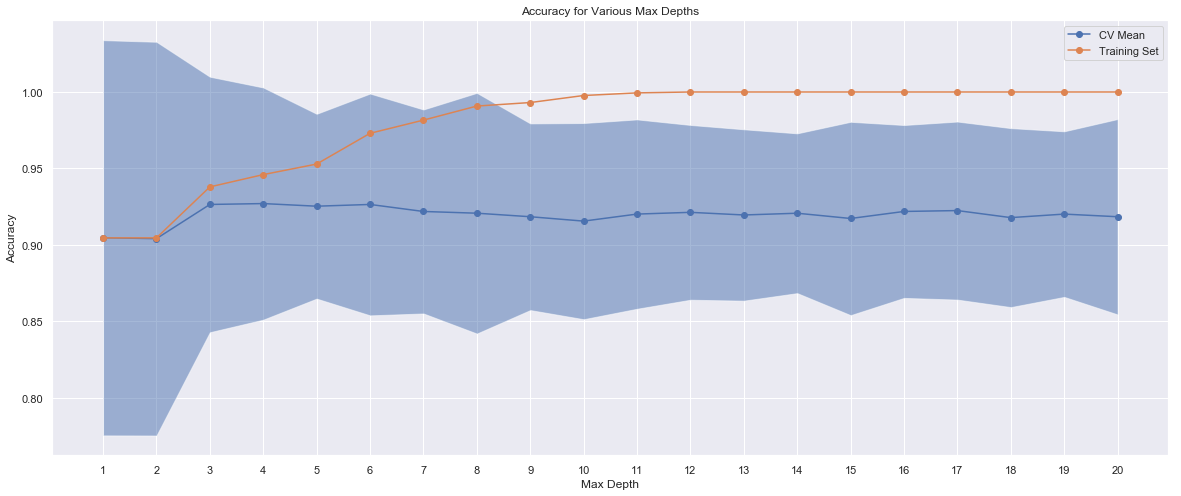

In [29]:
# Plot training accuracy and CV mean/std
fig, ax = plt.subplots(figsize=(20,8))

plt.plot(tree_depths, tree_cvmeans, 'o-', label="CV Mean")
plt.fill_between(tree_depths, np.array(tree_cvmeans) - 2*np.array(tree_cvstds), np.array(tree_cvmeans) + 2*np.array(tree_cvstds), alpha=0.5)
y_cv = plt.ylim()
plt.plot(tree_depths, tree_train_scores, 'o-', label="Training Set")
plt.xticks(tree_depths)

plt.legend()
plt.title("Accuracy for Various Max Depths")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.show()

In [30]:
# Selected variables
predictors_list = [x for x in list(df_features["feature"].values)  if x not in set([] + list_drops)]
# predictors_list = [x for x in list(df_features["feature"].values)]

# Create tree model with depth of 4
model_tree = DecisionTreeClassifier(max_depth=4).fit(X_train[predictors_list], y_train)
scores_tree = {
    "train": model_tree.score(X_train[predictors_list], y_train),
    "test": model_tree.score(X_test[predictors_list], y_test)
}

print(f"Tree train (2016 midterm election) accuracy score is: {scores_tree['train']*100}%")
print(f"Tree test (2018 midterm election) accuracy score is: {scores_tree['test']*100}%")


df_features_tree = pd.DataFrame({"feature_name": X_train[predictors_list].columns, "importance": model_tree.feature_importances_})
df_features_tree.sort_values(by=["importance"], ascending=False, inplace=True)

display(df_features_tree.head())

Tree train (2016 midterm election) accuracy score is: 94.59770114942529%
Tree test (2018 midterm election) accuracy score is: 86.4367816091954%


feature_name  importance
0            party_incumbent    0.784651
32  candidate_incumbent_vote    0.077866
3                Veteran PCT    0.061959
2            White alone PCT    0.044744
34       candidate_incumbent    0.018968

In [31]:
# Make predictions
y_predict_tree = {
    "train": model_tree.predict(X_train[predictors_list]),
    "test": model_tree.predict(X_test[predictors_list]),
}

# Show confusion matrix
confusion_matrix_tree = pd.DataFrame(confusion_matrix(y_test, y_predict_tree["test"]), columns=['predict D','predict R'])
confusion_matrix_tree.index=['true D','true R']
display(confusion_matrix_tree)


predict D  predict R
true D        180         58
true R          1        196

## Random Forest

In [32]:
# Selected variables
predictors_list = [x for x in list(df_features["feature"].values)  if x not in set([] + list_drops)]
# predictors_list = [x for x in list(df_features["feature"].values)]

# Try various number of trees
forest_estimators = [x*10 for x in range(1, 10)] + [x*50 for x in range(3, 8)]
forest_cvmeans = []
forest_cvstds = []
forest_train_scores = []
# Loop through depths and fit new model for each
for estimator in forest_estimators:
    model_forest_trial = RandomForestClassifier(n_estimators=estimator, max_depth=4,  max_features="auto")
    forest_train_scores.append(model_forest_trial.fit(X_train[predictors_list], y_train).score(X_train[predictors_list], y_train))
    # Store scores, cvmeans, and cvstds
    scores = cross_val_score(estimator=model_forest_trial, X=X_train[predictors_list], y=y_train, cv=5, n_jobs=-1)
    forest_cvmeans.append(scores.mean())
    forest_cvstds.append(scores.std())

In [33]:
# Show CV means/stds for various number of trees
df_scores_forest = pd.DataFrame({"n_estimators": forest_estimators, "cvmeans": forest_cvmeans, "cvstds": forest_cvstds})
df_scores_forest= df_scores_forest.sort_values(by=["cvmeans"], ascending=False)
display(df_scores_forest)

n_estimators   cvmeans    cvstds
2             30  0.931617  0.028343
1             20  0.925903  0.034491
13           350  0.924749  0.037660
11           250  0.923023  0.035156
6             70  0.920156  0.038123
7             80  0.918988  0.040956
8             90  0.918420  0.036551
10           200  0.916699  0.034754
12           300  0.916126  0.039909
5             60  0.915550  0.040569
4             50  0.915538  0.036381
9            150  0.914970  0.040661
3             40  0.909236  0.037639
0             10  0.893703  0.033258

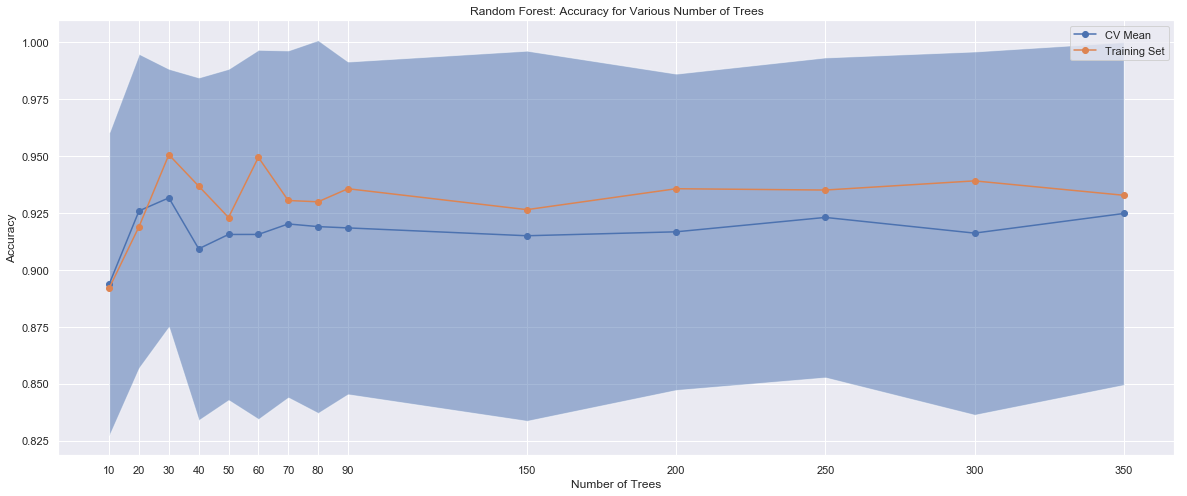

In [34]:
# Plot training accuracy and CV mean/std
fig, ax = plt.subplots(figsize=(20,8))

plt.plot(forest_estimators, forest_cvmeans, 'o-', label="CV Mean")
plt.fill_between(forest_estimators, np.array(forest_cvmeans) - 2*np.array(forest_cvstds), np.array(forest_cvmeans) + 2*np.array(forest_cvstds), alpha=0.5)
y_cv = plt.ylim()
plt.plot(forest_estimators, forest_train_scores, 'o-', label="Training Set")

# Focus y-axis and set x-ticks
# plt.ylim(y_cv)
plt.xticks(forest_estimators)

plt.legend()
plt.title("Random Forest: Accuracy for Various Number of Trees")
plt.ylabel("Accuracy")
plt.xlabel("Number of Trees")
plt.show()

In [35]:
forest_depths = list(range(1, 21))
forest_cvmeans2 = []
forest_cvstds2 = []
forest_train_scores2 = []
# Loop through depths and fit new model for each
for depth in forest_depths:
    model_forest_trial2 = DecisionTreeClassifier(max_depth=depth)
    forest_train_scores2.append(model_forest_trial2.fit(X_train[predictors_list], y_train).score(X_train[predictors_list], y_train))
    # Store scores, cvmeans, and cvstds
    scores = cross_val_score(estimator=model_forest_trial2, X=X_train[predictors_list], y=y_train, cv=5, n_jobs=-1)
    forest_cvmeans2.append(scores.mean())
    forest_cvstds2.append(scores.std())

In [36]:
# Show CV means/stds for various depths
df_scores_forest2 = pd.DataFrame({"max_depths": forest_depths, "cvmeans": forest_cvmeans2, "cvstds": forest_cvstds2})
df_scores_forest2 = df_scores_forest2.sort_values(by=["cvmeans"], ascending=False)
display(df_scores_forest2)

max_depths   cvmeans    cvstds
5            6  0.927608  0.038935
3            4  0.927029  0.037959
2            3  0.926451  0.041773
6            7  0.925314  0.027865
4            5  0.924159  0.029972
15          16  0.922447  0.029111
13          14  0.921294  0.029604
14          15  0.920724  0.033711
18          19  0.920722  0.028329
19          20  0.920146  0.026526
16          17  0.920146  0.027067
7            8  0.919583  0.032767
12          13  0.919002  0.032960
9           10  0.918995  0.029528
11          12  0.918427  0.026328
17          18  0.918415  0.029166
10          11  0.917271  0.029647
8            9  0.916706  0.032764
0            1  0.904672  0.064621
1            2  0.904097  0.064371

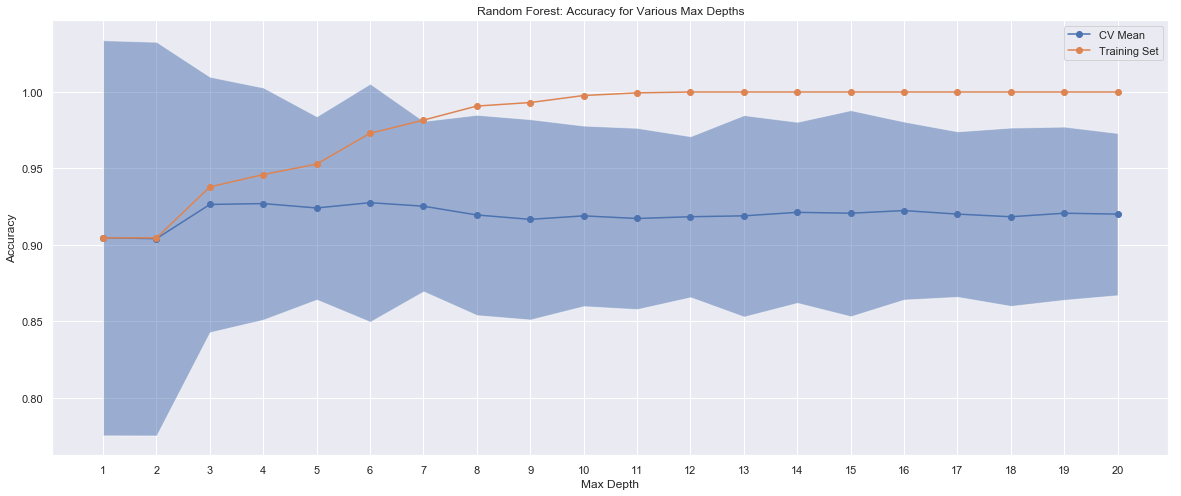

In [37]:
# Plot training accuracy and CV mean/std
fig, ax = plt.subplots(figsize=(20,8))

plt.plot(forest_depths, forest_cvmeans2, 'o-', label="CV Mean")
plt.fill_between(forest_depths, np.array(forest_cvmeans2) - 2*np.array(forest_cvstds2), np.array(forest_cvmeans2) + 2*np.array(forest_cvstds2), alpha=0.5)
y_cv = plt.ylim()
plt.plot(forest_depths, forest_train_scores2, 'o-', label="Training Set")

# Focus y-axis and set x-ticks
# plt.ylim(y_cv)
plt.xticks(forest_depths)

plt.legend()
plt.title("Random Forest: Accuracy for Various Max Depths")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.show()

In [64]:
# Selected variables
predictors_list = [x for x in list(df_features["feature"].values)  if x not in set([] + list_drops)]
# predictors_list = [x for x in list(df_features["feature"].values)]


# Create random forest model
model_forest = RandomForestClassifier(n_estimators=80, max_depth=6, max_features="auto").fit(X_train[predictors_list], y_train)

# Store scores
scores_forest = {
    "train": model_forest.score(X_train[predictors_list], y_train),
    "test": model_forest.score(X_test[predictors_list], y_test),
}

print(f"Forest train (2016 midterm election) accuracy score is: {scores_forest['train']*100}%")
print(f"Forest test (2018 midterm election) accuracy score is: {scores_forest['test']*100}%")

df_features_tree = pd.DataFrame(model_forest.feature_importances_,
                                   index = X_train[predictors_list].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

df_features_tree = pd.DataFrame({"importance": model_forest.feature_importances_, "feature": X_train[predictors_list].columns}).sort_values('importance', ascending=False)

display(df_features_tree.head())

Forest train (2016 midterm election) accuracy score is: 97.12643678160919%
Forest test (2018 midterm election) accuracy score is: 89.19540229885058%


importance                                            feature
0     0.324130                                    party_incumbent
1     0.114220  Income in the past 12 months at or above pover...
2     0.075190                                    White alone PCT
3     0.046814                                        Veteran PCT
14    0.044528  Agriculture, forestry, fishing and hunting, an...

In [65]:
# Show feature importance
df_features_tree = pd.DataFrame({"feature": X_train[predictors_list].columns, "importance": model_forest.feature_importances_}).sort_values('importance', ascending=False)
display(df_features_tree.head())

feature  importance
0                                     party_incumbent    0.324130
1   Income in the past 12 months at or above pover...    0.114220
2                                     White alone PCT    0.075190
3                                         Veteran PCT    0.046814
14  Agriculture, forestry, fishing and hunting, an...    0.044528

In [66]:
# Make predictions
y_predict_forest = {
    "train": model_forest.predict(X_train[predictors_list]),
    "test": model_forest.predict(X_test[predictors_list]),
}

# Show confusion matrix
confusion_matrix_forest = pd.DataFrame(confusion_matrix(y_test, y_predict_forest["test"]), columns=['predict Democrat','predict Republican'])
confusion_matrix_forest.index = ['true Democrat','true Republican']
display(confusion_matrix_forest)

# display(y_predict_forest["test"])

# Create csv of election result predictions
df_results = X_test[list(df_features_tree["feature"])].copy()
df_results["state_district"] = df_2018["state_district"]
df_results["prediction"] = y_predict_forest["test"]
df_results["actual"] = y_test
df_results["accuracy"] = np.where(df_results["prediction"] == df_results["actual"], 1, 0)
df_results.to_csv(f"data_out/results.csv", encoding='utf-8', index=False)
# display(df_results)

# Show the incorrect predictions
df_wrong = df_results[df_results["prediction"] != df_results["actual"]]
print(df_results.shape)
display(df_wrong.head())




predict Democrat  predict Republican
true Democrat                 192                  46
true Republican                 1                 196

(435, 39)


party_incumbent  Income in the past 12 months at or above poverty level:  White alone PCT  Veteran PCT  Agriculture, forestry, fishing and hunting, and mining PCT  Median housing value  Some other race alone PCT  Asian alone PCT  Black or African American alone PCT  Males 12th grade, no diploma PCT  candidate_incumbent  Professional, scientific, and management, and administrative and waste management services PCT  Male PCT  candidate_incumbent_vote  Females 12th grade, no diploma PCT  Hispanic or Latino (any race) PCT  Females Highschool diploma PCT  Total enrolled in private school PCT  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS  Median gross rent  Less than $10,000 PCT  Males unemployed PCT  Total enrolled in public school PCT  Per capita income   Two or more races PCT  Income in the past 12 months below poverty level  Males Highschool diploma PCT  Median age  Total not enrolled in school PCT  Aggregate income deficit in the past 12 months  American Indian & Alaska Native alone PCT  $200,000 or more PCT  Gini index of income inequality  Finance and insurance, and real estate and rental and leasing PCT  Females Bachelor's degree PCT state_district  prediction  actual  accuracy
1749              1.0                                           0.604505               0.805442     0.676295                                           0.035497                       0.120738                   0.112049         0.052188                             0.052958                          0.216926                  0.0                                           0.382897                                               0.505506                       0.0                            0.260918                           0.327430                        0.353475                              0.148688                                           0.264241                                                                                                          0.206557               0.177557              0.135354                             0.851312           0.273035                0.161695                                          0.290084                      0.344513    0.487805                          0.440777                                        0.166585                                   0.075291              0.158870                         0.385019                                           0.205590                                       0.431786       Arizona2           1       0         0
1762              1.0                                           0.582595               0.742975     0.242678                                           0.124262                       0.252136                   0.137014         0.130628                             0.042565                          0.623795                  0.0                                           0.268771                                               0.574936                       0.0                            0.596217                           0.505426                        0.529797                              0.087447                                           0.514340                                                                                                          0.392896               0.116769              0.145939                             0.912553           0.223731                0.194409                                          0.350014                      0.607517    0.282230                          0.213878                                        0.233412                                   0.035593              0.201627                         0.251908                                           0.151019                                       0.226357   California10           1       0         0
1774              1.0                                           0.417510               0.69

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


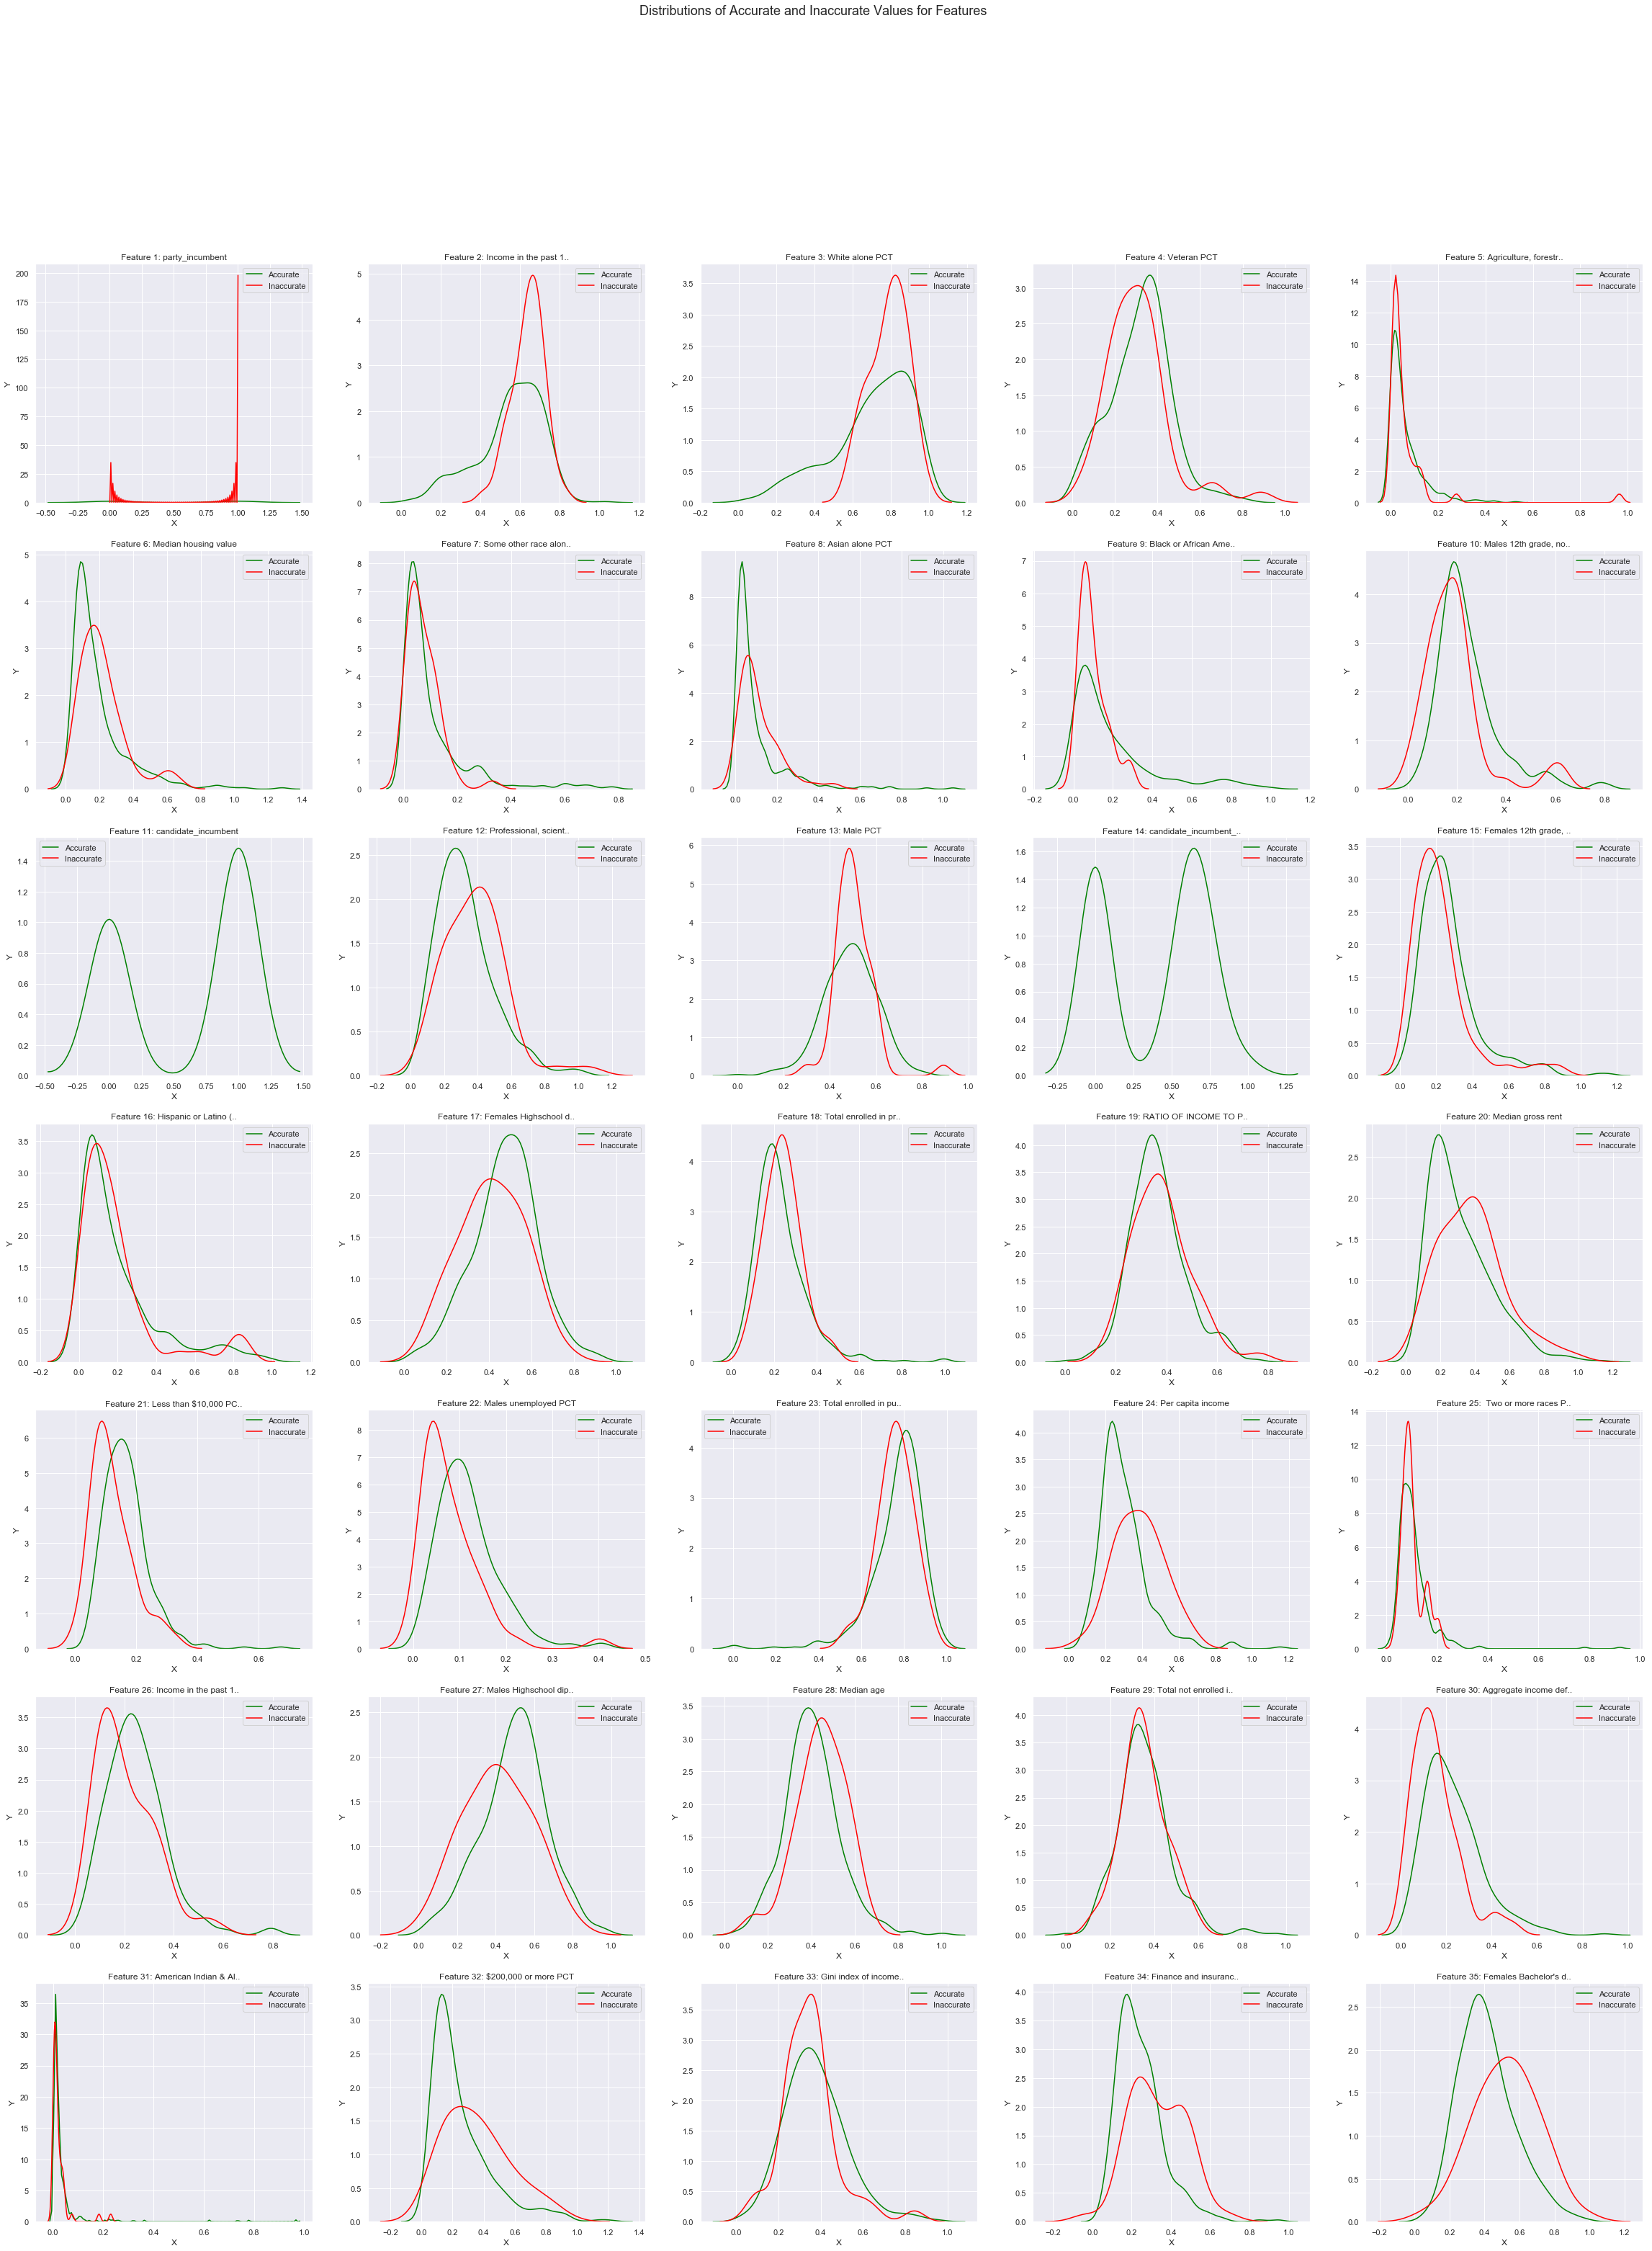

In [67]:
# Create plot for the 35 features
fig, ax = plt.subplots(7, 5, figsize=(40,50))

# Loop through each axis and feature
for i, ax_ in enumerate(ax.ravel()):
    sns.kdeplot(df_results[df_results["accuracy"] == 1.0].iloc[:, i], label="Accurate", color="green", ax=ax_)
    sns.kdeplot(df_results[df_results["accuracy"] == 0.0].iloc[:, i], label="Inaccurate", color="red", ax=ax_)
    
    # Set title and labels
    feature_name_raw = df_results.columns[i]
    feature_name = (feature_name_raw[:20] + '..') if len(feature_name_raw) > 20 else feature_name_raw
    ax_.set_title(f"Feature {i+1}: {feature_name}")
    ax_.set_xlabel("X")
    ax_.set_ylabel("Y")

plt.suptitle("Distributions of Accurate and Inaccurate Values for Features", fontsize=18)
# fig.tight_layout(rect=[0, 0.01, 1, 0.97])
plt.savefig(f"img_final/results_feature_distributions.png")
plt.show()



## Artifical Neural Networks

In [68]:
# Select variables
predictors_list = [x for x in list(df_features["feature"].values)  if x not in set(["R_win_pct"])]
# predictors_list = [x for x in list(df_features["feature"].values)]

In [69]:
y_train_NN = tf.keras.utils.to_categorical(y_train, 2)
y_test_NN = tf.keras.utils.to_categorical(y_test, 2)

X_train_normal = X_train_normal[predictors_list]
X_test_normal = X_test_normal[predictors_list]

DROPOUT_VALUE = 0.05
KERNEL_VALUE = 0.03
NODES = 20

model_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(NODES, input_shape=(X_train[predictors_list].shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(KERNEL_VALUE)),
    tf.keras.layers.Dropout(DROPOUT_VALUE),
    tf.keras.layers.Dense(int(NODES/2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(KERNEL_VALUE)),
    tf.keras.layers.Dropout(DROPOUT_VALUE),
    # tf.keras.layers.Dense(NODES, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(KERNEL_VALUE)),
    # tf.keras.layers.Dropout(DROPOUT_VALUE),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(KERNEL_VALUE)),
])
model_NN.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])
display(model_NN.summary())
# model_NN.compile(loss='mean_squared_error', optimizer="adam", metrics=['acc'])

model_history_NN = model_NN.fit(X_train[predictors_list], y_train_NN, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

print()
print(f"NN train accuracy score is: {model_history_NN.history['acc'][-1]*100}%")
print(f"NN val accuracy score is: {model_history_NN.history['val_acc'][-1]*100}%")
print(f"NN test accuracy score is: {model_NN.evaluate(X_test[predictors_list], y_test_NN)[1]*100}%")



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 1,092
Trainable params: 1,092
Non-trainable params: 0
_________________________________________________________________
Train on 1392 samples, validate on 348 samples
Epoch 1/100
1392/1392 - 1s - loss: 2.0041 - acc: 0.4267 - val_loss: 1.951

None

In [70]:
y_train_hat_NN = np.round(model_NN.predict(X_train_normal)).astype(int)
y_test_hat_NN = np.round(model_NN.predict(X_test_normal)).astype(int)

dec_tree_NN = DecisionTreeClassifier(max_depth=20)
dec_tree_NN.fit(X_train_normal, y_train_NN)

df_features_tree_NN = pd.DataFrame({"feature_name": X_train_normal.columns, "importance": dec_tree_NN.feature_importances_})
df_features_tree_NN.sort_values(by=["importance"], ascending=False, inplace=True)

display(df_features_tree_NN.head())

feature_name  importance
0                                     party_incumbent    0.658387
38                           candidate_incumbent_vote    0.065336
3                                         Veteran PCT    0.054118
2                                     White alone PCT    0.038706
14  Agriculture, forestry, fishing and hunting, an...    0.017766

## Model - Election Swing

In [76]:
# Build dataset that has whether state flipped parties or not
df_train_swing = df_train.copy()
df_2018_swing = df_2018.copy()

df_train_swing["swing"] = np.where(df_train_swing["party_result"] == df_train_swing["party_incumbent"], 0, 1)
df_2018_swing["swing"] = np.where(df_2018_swing["party_result"] == df_2018_swing["party_incumbent"], 0, 1)


y_train_swing = df_train_swing["swing"]
y_test_swing = df_2018_swing["swing"]

display(df_train_swing.head())
display(y_train_swing.head())

year state_district       party  party_incumbent  candidate_incumbent  candidate_incumbent_vote  R_win_pct  Median household income  Per capita income  Median housing value  Gini index of income inequality  Median gross rent  Median age  Median income  Income in the past 12 months below poverty level  Income in the past 12 months at or above poverty level:  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS  Aggregate income deficit in the past 12 months  Aggregate household income in the past 12 months (in 2016 inflation-adjusted dollars)  Male PCT  Female PCT  White alone PCT  Black or African American alone PCT  American Indian & Alaska Native alone PCT  Asian alone PCT  Native Hawaiian & Other Pacific Islander alone PCT  Some other race alone PCT   Two or more races PCT  Hispanic or Latino (any race) PCT  Speak only English PCT  Total not enrolled in school PCT  Total enrolled in public school PCT  Total enrolled in private school PCT  Males 12th grade, no diploma PCT  Males Highschool diploma PCT  Males Bachelor's degree PCT  Females 12th grade, no diploma PCT  Females Highschool diploma PCT  Females Bachelor's degree PCT  Males unemployed PCT  $200,000 or more PCT  Less than $10,000 PCT  Veteran PCT  Agriculture, forestry, fishing and hunting, and mining PCT  Finance and insurance, and real estate and rental and leasing PCT  \
0  2010       Alabama1  republican                1                    1                  0.982707      1.000                    41172              21773                136000                            0.478                709        38.4        21250.0                                             62151                                             393944                                                   156796                                                                                                                                    252961400.0                                        14275574200                                      0.490161    0.509839         0.673739                             0.282178                                   0.011597         0.014229                                           0.000077                    0.006597                0.011582                           0.028114                0.703508                          2.766175                             0.840151                              0.159849                          0.022878                      0.346345                     0.146185                            0.018299                        0.312136                       0.149800              0.013387              0.035159               0.078846     0.120964                                           0.015355                                                    0.057320                   
1  2010       Alabama2  republican                0                    0                  0.000000      1.000                    40567              21076                111200                            0.449                659        37.7        21548.0                                             50371                                             371220                                                   150164                                                                                                                                    225112400.0                                        13534983400                                      0.479372    0.520628         0.647390                             0.309302                                   0.004069         0.008810                                           0.000268                    0.008756                0.021406                           0.027876                0.703508                          2.765390                             0.839394                              0.160606                          0.017206                

0    0
1    1
2    0
3    0
4    1
Name: swing, dtype: int64

In [77]:
# Selected variables
predictors_list = [x for x in list(df_features["feature"].values)  if x not in set([] + list_drops)]
# predictors_list = [x for x in list(df_features["feature"].values)]


# Create random forest model
model_forest_swing = RandomForestClassifier(n_estimators=80, max_depth=6, max_features="auto").fit(X_train[predictors_list], y_train_swing)

# Store scores
scores_forest_swing = {
    "train": model_forest_swing.score(X_train[predictors_list], y_train_swing),
    "test": model_forest_swing.score(X_test[predictors_list], y_test_swing),
}

print(f"Forest train (2016 midterm election) accuracy score is: {scores_forest_swing['train']*100}%")
print(f"Forest test (2018 midterm election) accuracy score is: {scores_forest_swing['test']*100}%")

df_features_tree_swing = pd.DataFrame(model_forest_swing.feature_importances_,
                                   index = X_train[predictors_list].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

df_features_tree_swing = pd.DataFrame({"feature": X_train[predictors_list].columns, "importance": model_forest_swing.feature_importances_,}).sort_values('importance', ascending=False)

display(df_features_tree_swing.head())

Forest train (2016 midterm election) accuracy score is: 94.13793103448276%
Forest test (2018 midterm election) accuracy score is: 87.58620689655172%


feature  importance
34       candidate_incumbent    0.197709
32  candidate_incumbent_vote    0.140901
0            party_incumbent    0.064565
3                Veteran PCT    0.055482
18                  Male PCT    0.029135

In [78]:
# Make predictions
y_predict_forest_swing = {
    "train": model_forest_swing.predict(X_train[predictors_list]),
    "test": model_forest_swing.predict(X_test[predictors_list]),
}

# Create csv of election swing predictions
df_results_swing = X_test[list(df_features_tree_swing["feature"])].copy()
df_results_swing["state_district"] = df_2018_swing["state_district"]
df_results_swing["prediction"] = y_predict_forest_swing["test"]
df_results_swing["actual"] = y_test_swing
df_results_swing["accuracy"] = np.where(df_results_swing["prediction"] == df_results_swing["actual"], 1, 0)
df_results_swing.to_csv(f"data_out/results.csv", encoding='utf-8', index=False)
# display(df_results)

# Show the incorrect predictions
df_wrong_swing = df_results_swing[df_results_swing["prediction"] != df_results_swing["actual"]]
print(df_results_swing.shape)
display(df_wrong_swing.head())




(435, 39)


candidate_incumbent  candidate_incumbent_vote  party_incumbent  Veteran PCT  Male PCT  White alone PCT  Males unemployed PCT  Median gross rent  $200,000 or more PCT  Income in the past 12 months at or above poverty level:   Two or more races PCT  Per capita income  Females Bachelor's degree PCT  Hispanic or Latino (any race) PCT  Aggregate income deficit in the past 12 months  Asian alone PCT  Some other race alone PCT  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS BY NATIVITY OF CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NATIVITY OF PARENTS  Professional, scientific, and management, and administrative and waste management services PCT  Gini index of income inequality  Median housing value  Less than $10,000 PCT  Females Highschool diploma PCT  American Indian & Alaska Native alone PCT  Females 12th grade, no diploma PCT  Income in the past 12 months below poverty level  Agriculture, forestry, fishing and hunting, and mining PCT  Total not enrolled in school PCT  Males Highschool diploma PCT  Males 12th grade, no diploma PCT  Black or African American alone PCT  Total enrolled in private school PCT  Total enrolled in public school PCT  Finance and insurance, and real estate and rental and leasing PCT  Median age state_district  prediction  actual  accuracy
1749                  0.0                       0.0              1.0     0.676295  0.505506         0.805442              0.135354           0.206557              0.158870                                           0.604505                      0.161695           0.273035                       0.431786                           0.327430                                        0.166585         0.052188                   0.112049                                           0.264241                                                                                                                                          0.382897                                                                      0.385019              0.120738               0.177557                        0.353475                                   0.075291                            0.260918                                          0.290084                                           0.035497                                   0.440777                      0.344513                          0.216926                             0.052958                              0.148688                             0.851312                                           0.205590                    0.487805       Arizona2           0       1         0
1762                  0.0                       0.0              1.0     0.242678  0.574936         0.742975              0.145939           0.392896              0.201627                                           0.582595                      0.194409           0.223731                       0.226357                           0.505426                                        0.233412         0.130628                   0.137014                                           0.514340                                                                                                                                          0.268771                                                                      0.251908              0.252136               0.116769                        0.529797                                   0.035593                            0.596217                                          0.350014                                           0.124262                                   0.213878                      0.607517                          0.623795                             0.042565                              0.087447                             0.912553                                           0.151019                    0.282230   California10           0       1         0
1774                  0.0                       0.0              1.0     0.161042  0.892580

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


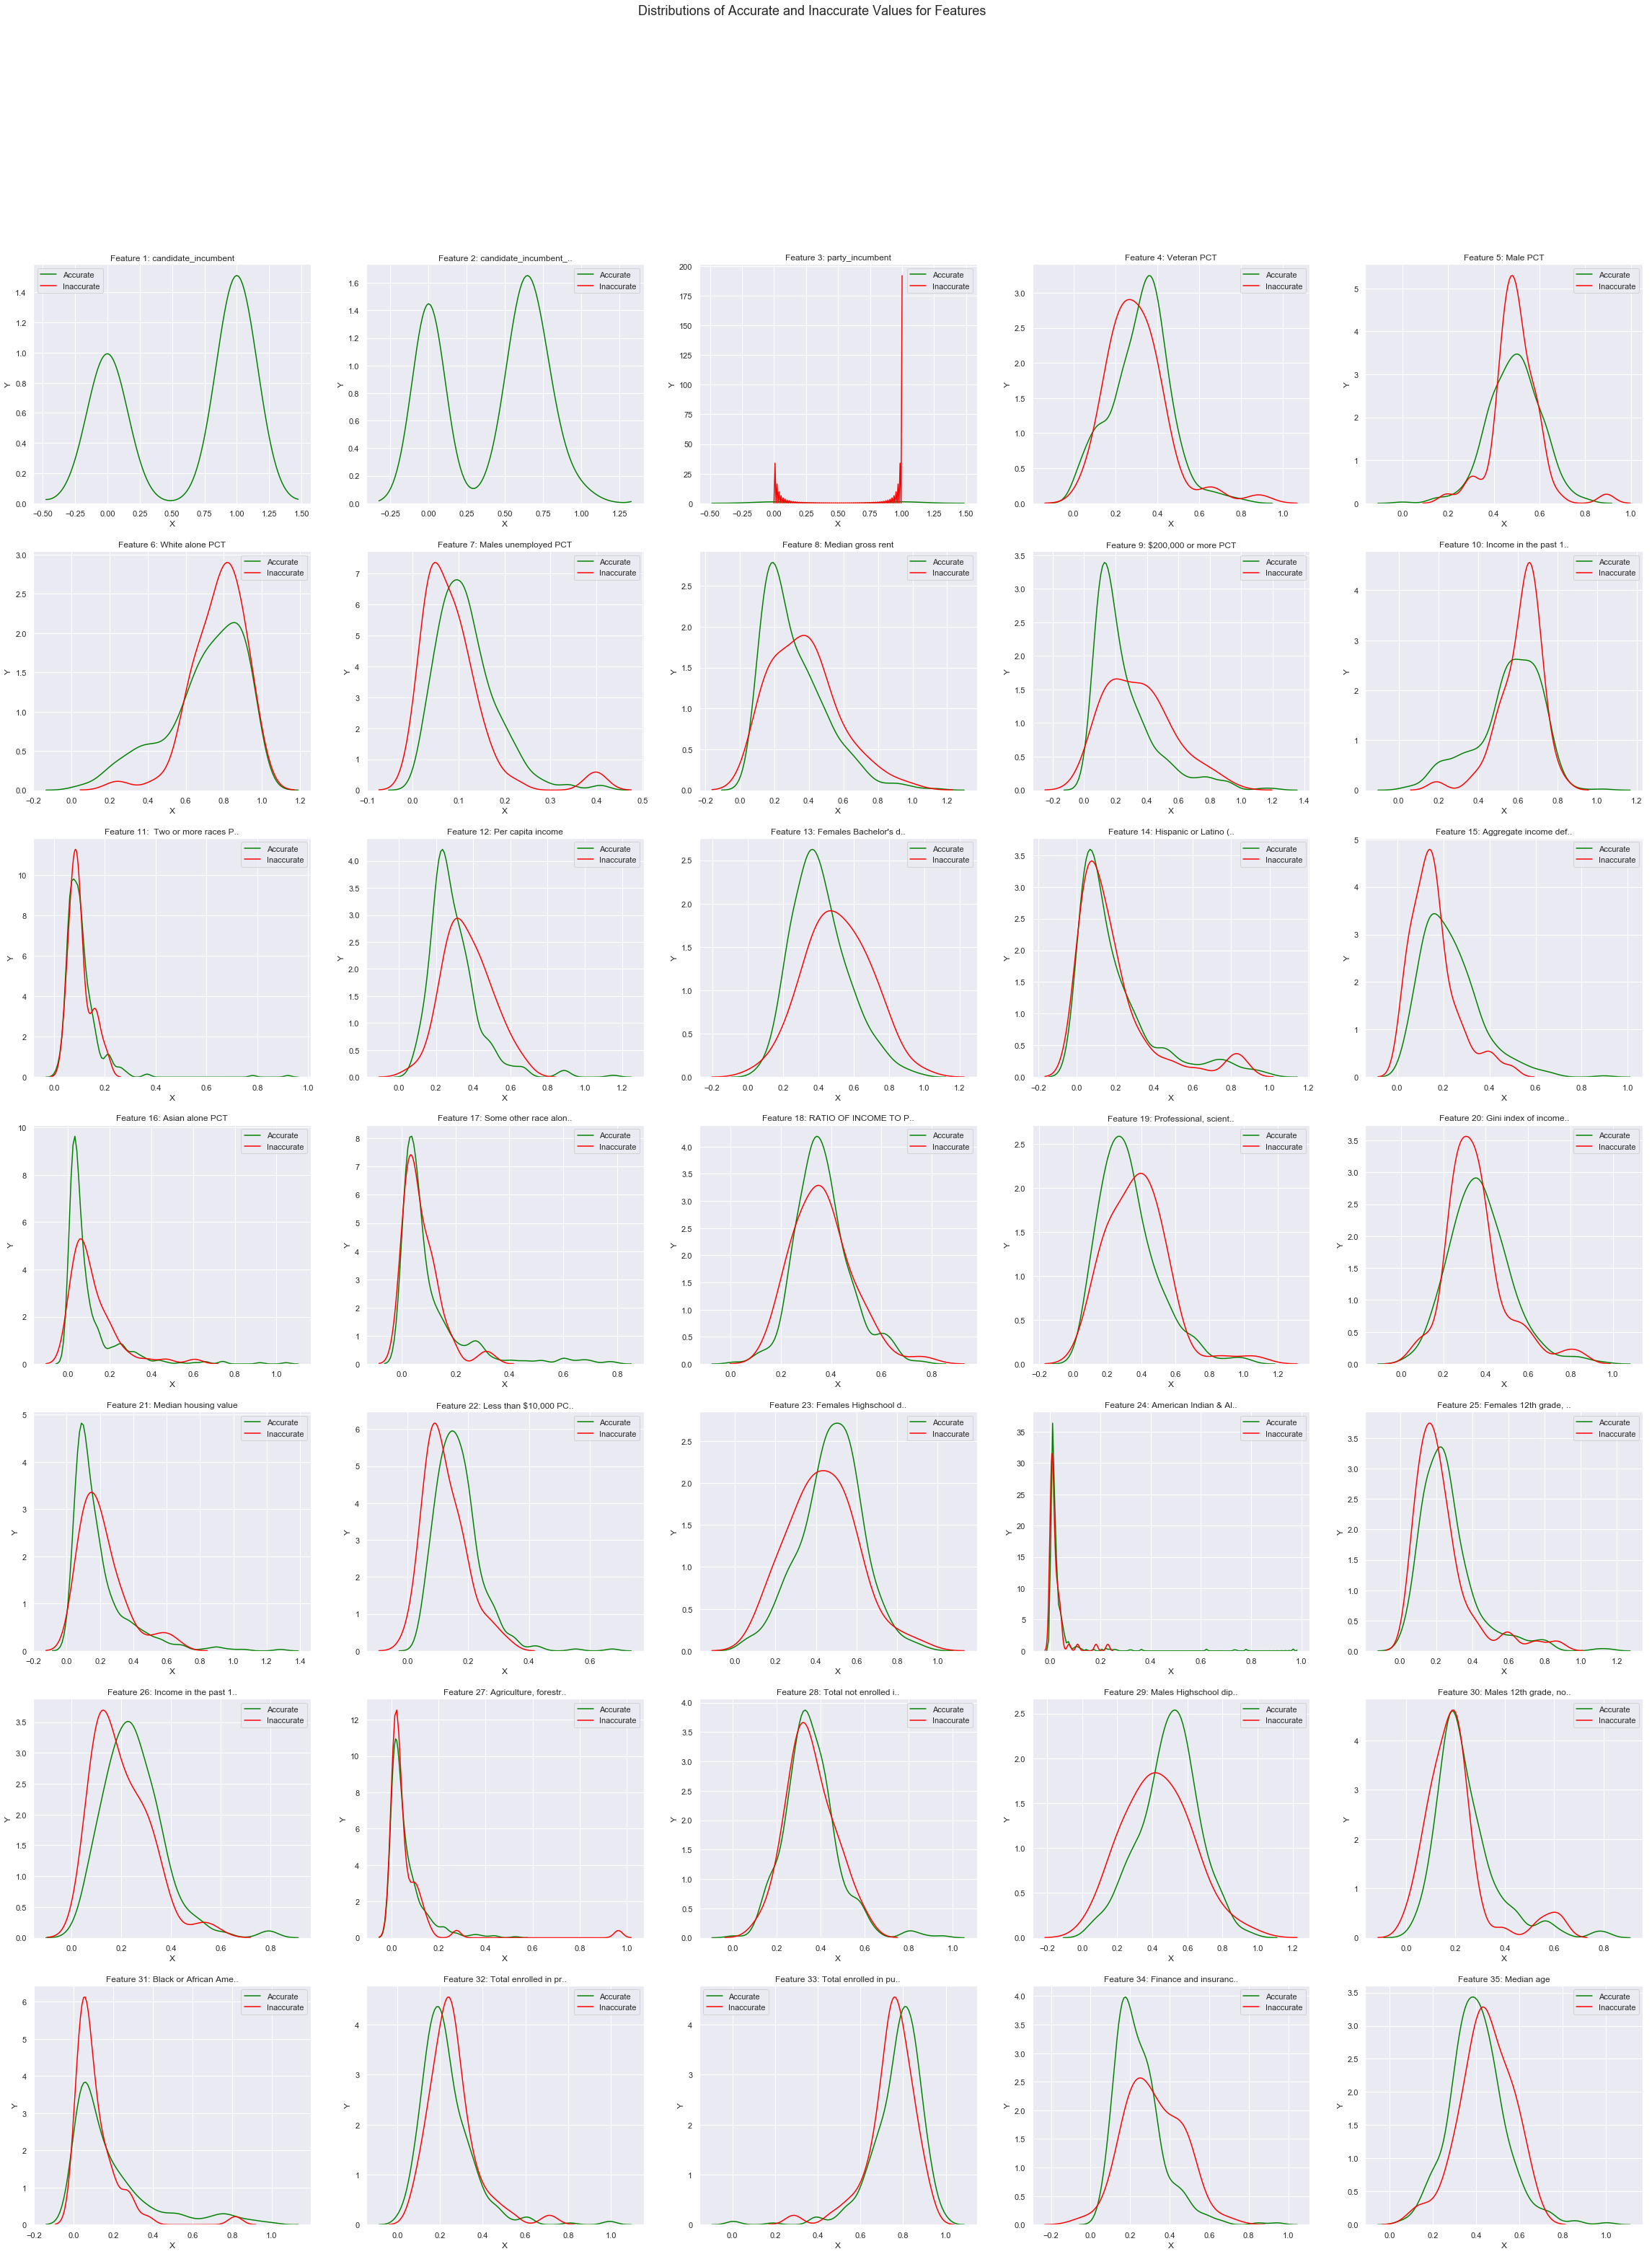

In [79]:
# Create plot for the 35 features
fig, ax = plt.subplots(7, 5, figsize=(40,50))

# Loop through each axis and feature
for i, ax_ in enumerate(ax.ravel()):
    sns.kdeplot(df_results_swing[df_results_swing["accuracy"] == 1.0].iloc[:, i], label="Accurate", color="green", ax=ax_)
    sns.kdeplot(df_results_swing[df_results_swing["accuracy"] == 0.0].iloc[:, i], label="Inaccurate", color="red", ax=ax_)
    
    # Set title and labels
    feature_name_raw = df_results_swing.columns[i]
    feature_name = (feature_name_raw[:20] + '..') if len(feature_name_raw) > 20 else feature_name_raw
    ax_.set_title(f"Feature {i+1}: {feature_name}")
    ax_.set_xlabel("X")
    ax_.set_ylabel("Y")

plt.suptitle("Distributions of Accurate and Inaccurate Values for Features", fontsize=18)
# fig.tight_layout(rect=[0, 0.01, 1, 0.97])
plt.savefig(f"img_final/results_swing_feature_distributions.png")
plt.show()
